In [ ]:
# Import necessary libraries
from sklearn.datasets import fetch_openml, load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import umap.umap_ as umap
from sklearn.metrics import pairwise_distances
from helper import normalize, simple_matching_distance, pairwise_hamming_distance_similarity
import warnings

warnings.filterwarnings('ignore')

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes

- maybe too many plots?
- maybe reuse code for MNIST and BCW datasets (visualizations)
- add Table of Contents
- figure out if we want to normalize the data, that the values are more reasonable
- I used breast canacer wisconsin, as it is a classic medical dataset. However it is not connected to neurorehabilitation, should we change it?
- Visualizations of Categorical Distance matrices and gowers distance matrix look interesting. I have never done something like this, will check if this is common (Looks reasonable in my opinion)
- the explained variance in the pca of bwc example is way greater in my example than in the ones I found online? https://www.sciencedirect.com/science/article/pii/S1877050924033623
- Still not sure how links work here
- maybe hide some code

# Table of Contents

[Introduction to the MNIST Dataset](#Introduction-to-the-MNIST-Dataset)
- [1. Visualization with Dimensionality Reduction](#1.-Visualization-with-Dimensionality-Reduction)
  - [Principal Component Analysis (PCA)](#Principal-Component-Analysis-(PCA))
  - [Multidimensional Scaling (MDS)](#Multidimensional-Scaling-(MDS))
  - [t-Distributed Stochastic Neighbor Embedding (t-SNE)](#t-Distributed-Stochastic-Neighbor-Embedding-(t-SNE))
  - [Uniform Manifold Approximation and Projection (UMAP)](#Uniform-Manifold-Approximation-and-Projection-(UMAP))
  - [Dimensionality Reduction Overview](#Dimensionality-Reduction-Overview)
- [2. Visualizing High-Dimensional Medical Datasets](#2.-Visualizing-High-Dimensional-Medical-Datasets)
  - [Introduction to the Breast Cancer Wisconsin Dataset](#Introduction-to-the-Breast-Cancer-Wisconsin-Dataset)
  - [Principle Component Analysis (PCA)](#Principle-Component-Analysis-(PCA))
  - [Multidimensional Scaling (MDS)](#Multidimensional-Scaling-(MDS))
  - [t-SNE](#t-SNE)
  - [UMAP](#UMAP)
  - [Overview](#Overview)
- [3. Similarity](#3.-Similarity)
  - [Similarity Metrics for Continuous Data](#Similarity-Metrics-for-Continuous-Data)
    - [Visualizing Similarity Matrices](#Visualizing-Similarity-Matrices)
  - [Similarity Metrics for Categorical Data](#Similarity-Metrics-for-Categorical-Data)
    - [Introduction to the Stroke Prediction Dataset](#Introduction-to-the-Stroke-Prediction-Dataset)
  - [Similarity Metrics for Mixed Data](#Similarity-Metrics-for-Mixed-Data)
  - [Overview Similarity](#Overview-Similarity)

<br><br>
# **Hands-On: Dimensionality Reduction and Similarity**

## Learning Goals
By the end of this session, you will be able to:

- **Apply dimensionality reduction techniques for visualization**
  - Use PCA, MDS, t-SNE, and UMAP to visualize high-dimensional datasets like MNIST and medical data
  - Compare strengths and limitations of different dimensionality reduction methods

- **Understand dimensionality reduction algorithms**
  - Distinguish between linear (PCA, MDS) and non-linear (t-SNE, UMAP) approaches
  - When to use each technique based on data characteristics and visualization goals

- **Compute and interpret similarity metrics**
  - Calculate similarity for continuous, categorical, and mixed data types
  - Visualize similarity matrices and understand distance-based relationships between datapoints

## Introduction to the MNIST Dataset

The **MNIST dataset** (Modified National Institute of Standards and Technology) is a classic collection of handwritten digit images, widely used as a benchmark for machine learning algorithms, especially in the fields of image classification and dimensionality reduction.

- **Images:** 70,000 images of handwritten digits (0–9), each sized 28×28 pixels
- **Training set:** 60,000 images
- **Test set:** 10,000 images
- **Pixel values:** Grayscale, ranging from 0 (white) to 255 (black)
- **Labels:** Each image is labeled with the digit it represents (0–9)
- **Data format:** Each 28×28 image is often "flattened" into a 784-dimensional vector for analysis (High-Dimension!)

**Why MNIST?**  
Although MNIST is not a medical dataset, it provides a simple and visual way to understand techniques like dimensionality reduction and similarity search, which are also applicable to healthcare data (e.g., recognizing patterns in medical images).

MNIST’s simplicity and accessibility have made it a standard tool for testing and comparing algorithms.

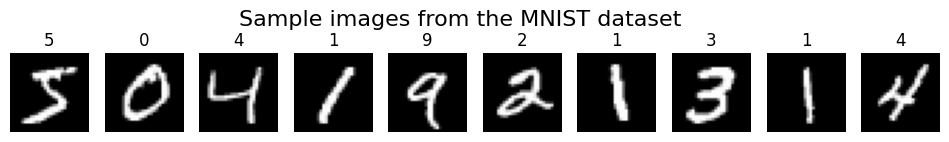

In [24]:
# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)  # Convert outcome to int

# Display 10 sample images
fig, axes = plt.subplots(1, 10, figsize=(12, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(str(y[i]), fontsize=12)
    ax.axis("off")
plt.suptitle("Sample images from the MNIST dataset", fontsize=16, y=1.05)
plt.show()

# 1. Visualization with Dimensionality Reduction

Many real-world datasets, like images, have hundreds or thousands of features, making them impossible to visualize directly. **Dimensionality reduction** techniques help us project such high-dimensional data into 2 or 3 dimensions, allowing us to visualize and better understand the structure and patterns within the data.

## Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)** is a fundamental technique for dimensionality reduction. It transforms high-dimensional data into a lower-dimensional space while preserving as much variability (information) as possible.

- **How does it work?**  
  PCA identifies the directions (principal components) where the data varies the most. The first principal component captures the most variance, the second is orthogonal to the first and captures the next highest variance, and so on.
- **Why use it?**  
  By projecting high-dimensional data onto the first few principal components, we can visualize complex datasets and uncover their underlying structure.

In this step, we'll project the 784-dimensional MNIST images onto the first two principal components and visualize the result.

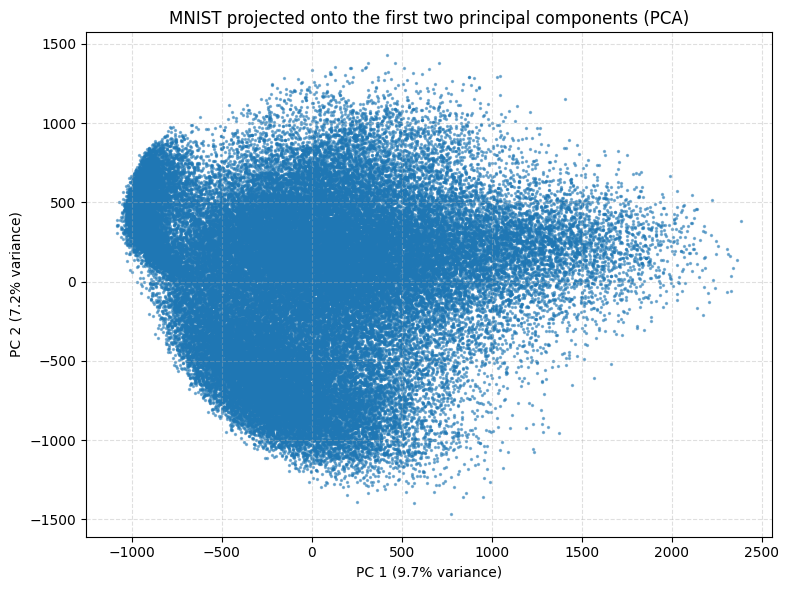

In [25]:
# Choose how many samples to visualize, later we use a subset for efficiency
n_samples = 70000
X_subset = X[:n_samples]
y_pca = y[:n_samples].astype(int)

# Fit PCA and transform the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# Plot the PCA projection (without coloring by label yet)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2, alpha=0.5)
plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("MNIST projected onto the first two principal components (PCA)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

The scatter plot above displays each MNIST image as a point, projected onto the first two principal components.  
- **PC 1 and PC 2** represent the directions of greatest variance in the dataset.
- The **explained variance percentages** in the axis labels indicate how much of the dataset’s total variability is captured by each component. In this case *PC1* explains 9.7% of the variance in the data and *PC2* explains 7.2%.

At this stage, we’re not using any color to represent the digit labels.  
In the next step, we’ll color the points to explore how different digits are distributed in this reduced space.

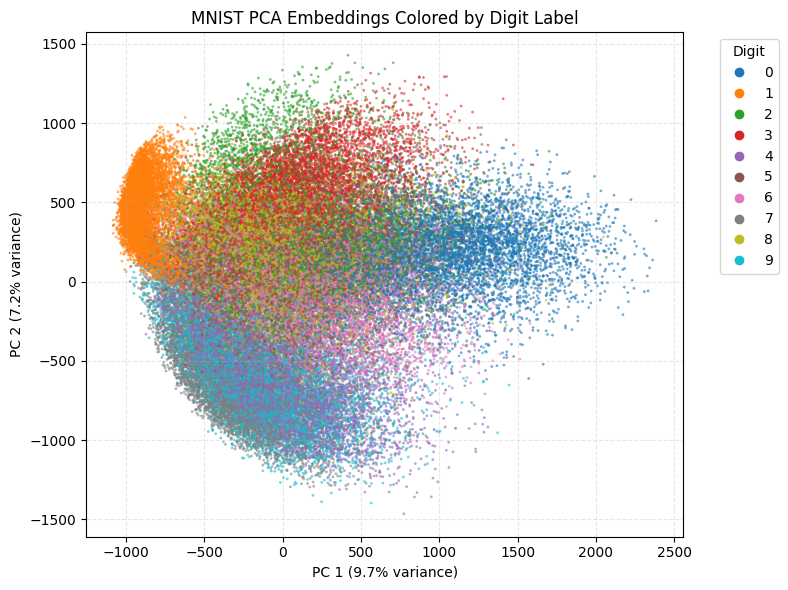

In [26]:
# Make sure y is an integer array for color mapping
labels = y_pca.astype(int)

# Create a color map: one unique color for each digit
cmap = plt.get_cmap('tab10', 10)  # 'tab10' has 10 distinct colors

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels,
    cmap=cmap,
    s=4,
    alpha=0.6,
    edgecolors='none'
)

# Create a legend, one entry per digit
legend_labels = [str(i) for i in range(10)]
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=cmap(i), label=legend_labels[i])
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.title("MNIST PCA Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

As we can see in the plot above, images of the digit **1** tend to cluster closely together, indicating that their representations are quite consistent in the PCA-reduced space. In contrast, images of the other digits are more spread out and often overlap with each other.

## Multidimensional Scaling (MDS)

**Multidimensional Scaling (MDS)** is another dimensionality reduction technique.  
Instead of focusing on variance (like PCA), MDS aims to preserve the pairwise distances between samples when projecting high-dimensional data into a lower-dimensional space. This can reveal different structures and relationships within the dataset.

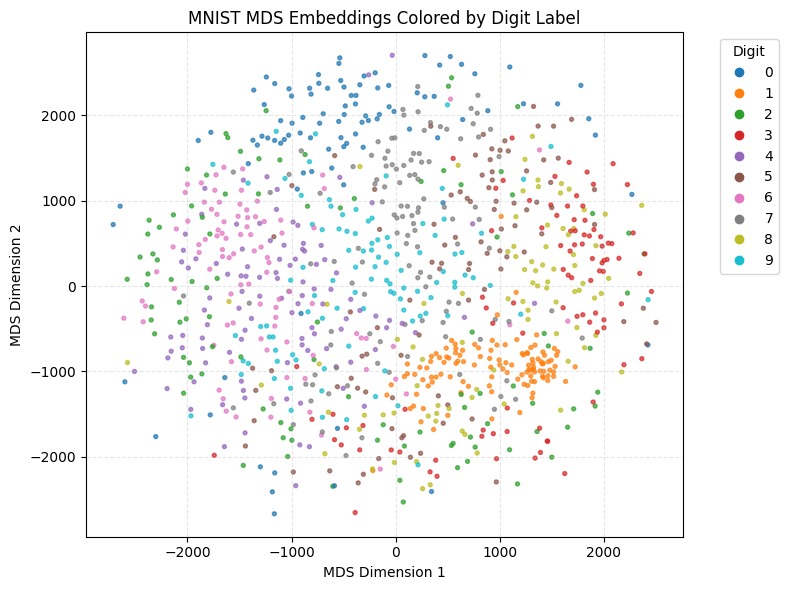

In [27]:
# MDS can be slow on large datasets. For demonstration, we'll use a subset.
n_samples = 1000  # You can increase if your machine allows
X_subset = X[:n_samples]
y_mds = y[:n_samples].astype(int)

# Fit and transform with MDS
mds = MDS(n_components=2, random_state=42, n_init=1, max_iter=300, verbose=1)
X_mds = mds.fit_transform(X_subset)

# Plot the MDS embeddings colored by digit label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_mds[:, 0], X_mds[:, 1],
    c=y_mds,
    cmap=plt.get_cmap('tab10', 10),
    s=8, alpha=0.7
)
# Create a legend for digit labels
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=str(i))
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("MNIST MDS Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

**t-SNE** is a popular nonlinear dimensionality reduction algorithm, especially useful for visualizing high-dimensional data.  
Unlike PCA or MDS, t-SNE is designed to preserve local structure, meaning that similar points in high-dimensional space stay close together in the lower-dimensional map. This often results in clearer clusters for data like images or text.

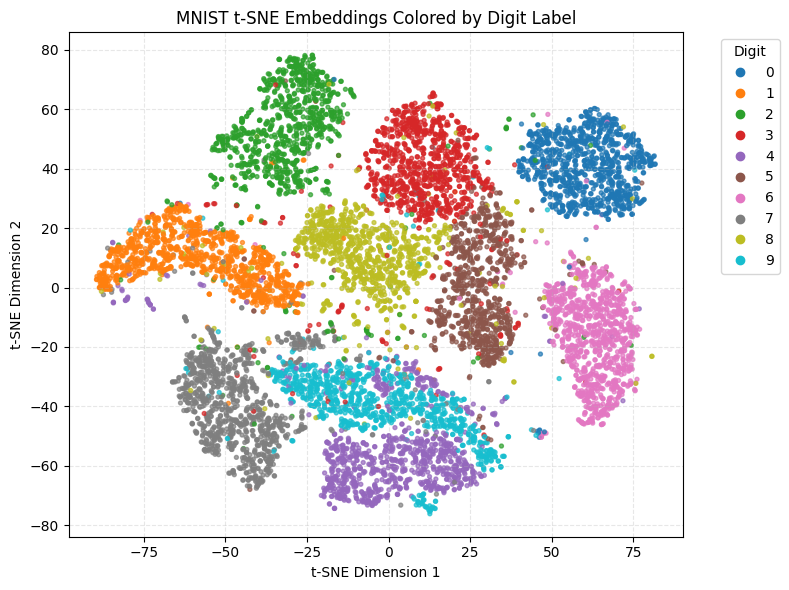

In [28]:
# t-SNE is computationally intensive; use a manageable subset
n_samples = 10000  # Adjust as needed for speed
X_subset = X[:n_samples]
y_tsne = y[:n_samples].astype(int)

# Fit and transform with t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_tsne = tsne.fit_transform(X_subset)

# Plot the t-SNE embeddings colored by digit label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_tsne,
    cmap=plt.get_cmap('tab10', 10),
    s=8, alpha=0.7
)
# Create a legend for digit labels
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=str(i))
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("MNIST t-SNE Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Uniform Manifold Approximation and Projection (UMAP)

**UMAP** is a powerful nonlinear dimensionality reduction technique, similar to t-SNE but often faster and better at preserving both local and global data structure.  
UMAP is widely used for visualizing high-dimensional datasets, revealing clusters and patterns that might not be visible with linear methods like PCA.

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


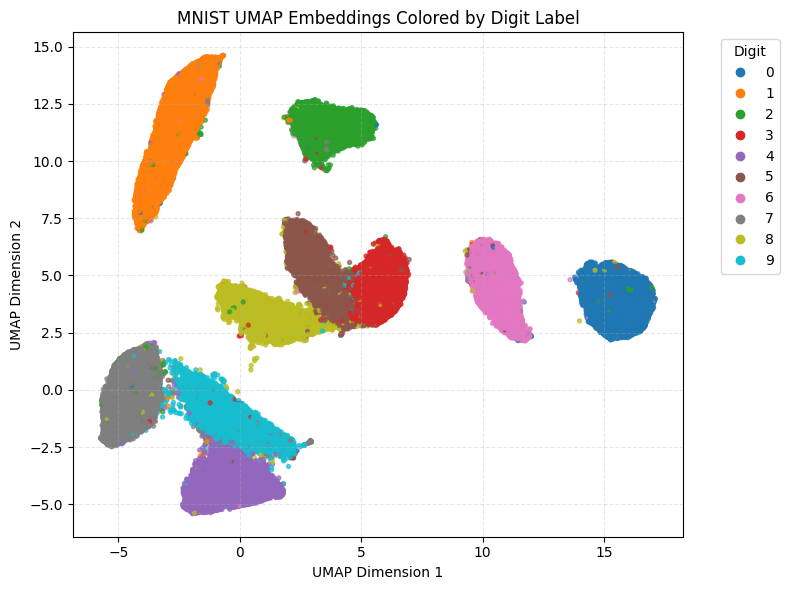

In [29]:
# UMAP is efficient but we'll still use a subset for consistency
n_samples = 70000
X_subset = X[:n_samples]
y_umap = y[:n_samples].astype(int)

# Fit and transform with UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_subset)

# Plot the UMAP embeddings colored by digit label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=y_umap,
    cmap=plt.get_cmap('tab10', 10),
    s=8, alpha=0.7
)
# Create a legend for digit labels
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=plt.cm.tab10(i), label=str(i))
    for i in range(10)
]
plt.legend(handles=handles, title="Digit", bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("MNIST UMAP Embeddings Colored by Digit Label")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Dimensionality Reduction Overview

Here is a brief summary of the four dimensionality reduction techniques we explored:

- **PCA (Principal Component Analysis)**
  - Linear technique projecting data onto directions of greatest variance
  - Fast and interpretable, but limited to linear relationships

- **MDS (Multidimensional Scaling)**  
  - Preserves pairwise distances between samples in lower-dimensional space
  - Useful for visualizing similarity relationships

- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**
  - **Advantage**: Preserves nonlinear neighborhood structures and reveals clusters clearly
  - **Limitations**: 
    - Dependent on random seed → different initializations can yield different results
    - Only short distances within clusters (local neighborhoods) are interpretable
    - Distances between clusters are not meaningful

- **UMAP (Uniform Manifold Approximation and Projection)**
  - **Advantages**: 
    - Not dependent on random seed → consistent results across runs
    - Both short distances (within clusters) and long distances (between clusters) are interpretable
    - Fast and scales well to large datasets
  - **Characteristic**: Often produces plots with empty space between well-separated clusters

**Disadvantages of PCA and MDS:**
- Both assume data can be well-represented by a linear subspace (e.g., a flat plane for 2D plotting)
- However, there's rarely a good reason why real-world data should lie in a linear plane
- Cannot capture complex, nonlinear neighborhood structures

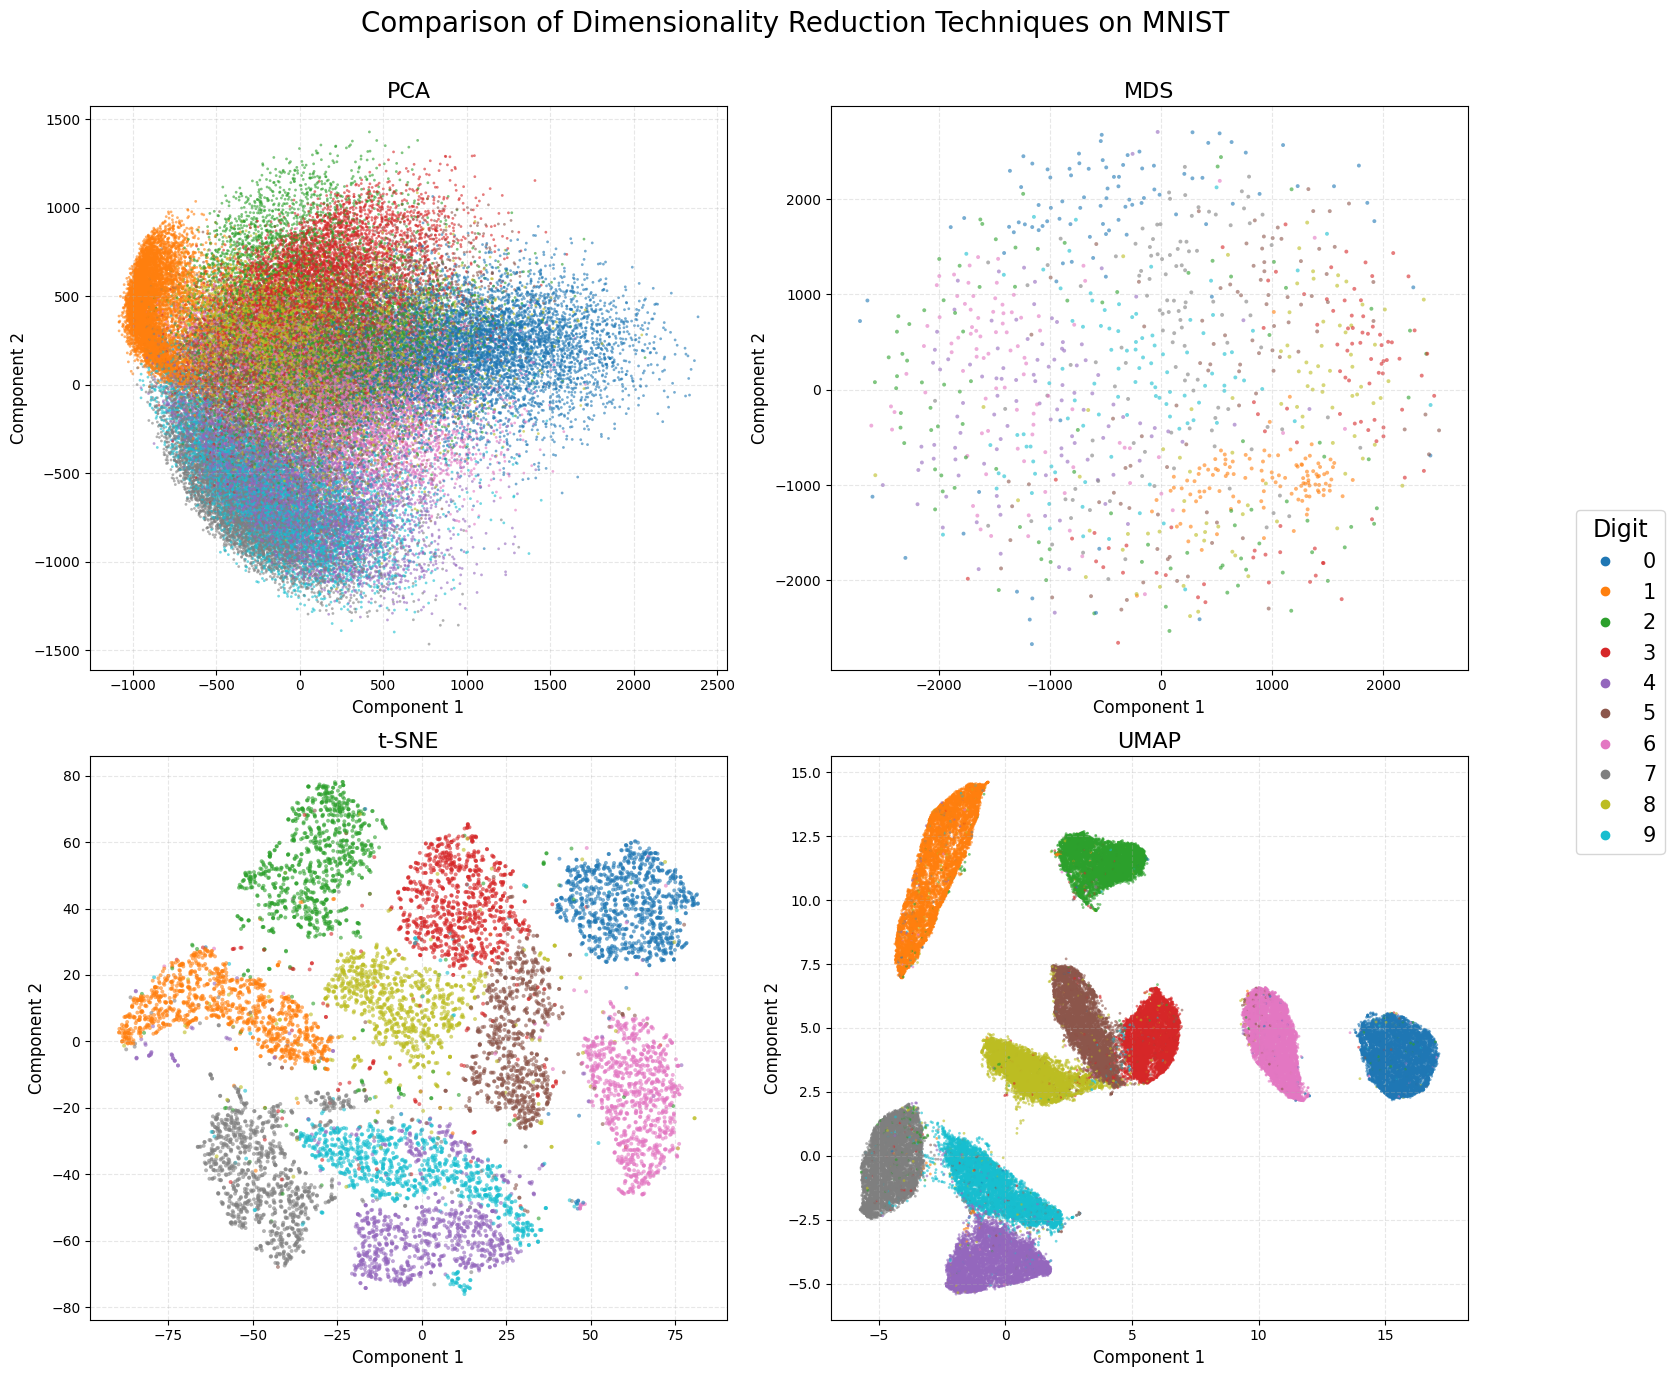

In [30]:
# Each embedding and label set
embeddings = [
    (X_pca, y_pca, "PCA"),
    (X_mds, y_mds, "MDS"),
    (X_tsne, y_tsne, "t-SNE"),
    (X_umap, y_umap, "UMAP"),
]

cmap = plt.get_cmap('tab10', 10)

fig, axs = plt.subplots(2, 2, figsize=(16, 14))

for ax, (emb, labels, title) in zip(axs.flat, embeddings):
    sc = ax.scatter(
        emb[:, 0], emb[:, 1],
        c=labels.astype(int),
        cmap=cmap,
        s=4 if len(labels) > 10000 else 8,  # Smaller points for larger sets
        alpha=0.6,
        edgecolors='none'
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Component 1", fontsize=12)
    ax.set_ylabel("Component 2", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

# Legend (only once for all plots)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", color=cmap(i), label=str(i))
    for i in range(10)
]
fig.legend(handles=handles, title="Digit", loc='center right', bbox_to_anchor=(1.05, 0.5), fontsize=15, title_fontsize=17)

plt.suptitle("Comparison of Dimensionality Reduction Techniques on MNIST", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 0.93, 0.97])
plt.show()

---
<br><br>
# 2. Visualizing High-Dimensional Medical Datasets

So far, we've explored how dimensionality reduction techniques can uncover patterns and structure in benchmark datasets like MNIST.  
Now, let's take the next step and apply these powerful tools to real clinical data.

In this section, we'll use the **Breast Cancer Wisconsin dataset** as a practical example. We'll see how techniques like PCA, t-SNE, and UMAP can project patient data into two dimensions, making hidden patterns and diagnostic groups visible—even in complex, high-dimensional medical spaces.

## Introduction to the Breast Cancer Wisconsin Dataset

The **Breast Cancer Wisconsin (Diagnostic) dataset** is a widely used benchmark in the biomedical machine learning community. It contains features computed from digitized images of breast mass tissue, which help clinicians and researchers distinguish between benign and malignant tumors.

- **Samples:** 569 breast mass cases
- **Features:** 30 numeric features, computed from a digitized image of a fine needle aspirate (FNA) of a breast mass  
  (e.g., radius, texture, perimeter, area, smoothness, etc.)
- **Labels:** 
    - `0` = malignant (cancerous)
    - `1` = benign (non-cancerous)
- **Data type:** All features are continuous, numeric (floating-point)
- **No missing values:** The dataset is complete and ready for analysis
- **Normalization:** We normalize the dataset for clarity

Its clarity, moderate size, and clinical importance make it ideal for visualizing and understanding algorithms like PCA, MDS, t-SNE, and UMAP in a real-world biomedical setting.

In [31]:
# Load dataset
data = load_breast_cancer()
X, y = normalize(data['data']), data['target']
feature_names = data['feature_names']
outcome_names = data['target_names']

# Convert to DataFrame for convenience
df = pd.DataFrame(X, columns=feature_names)
df['outcome'] = y

In [32]:
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.192296     -0.225630        0.266798   4.113535        -0.270578   
1    -0.180995     -0.193260        0.311039   5.537116        -0.270726   
2    -0.184850     -0.178017        0.298336   4.998345        -0.270617   
3    -0.221074     -0.181827        0.068723   1.420118        -0.270473   
4    -0.182222     -0.208284        0.320675   5.410089        -0.270658   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0         -0.269881       -0.269782            -0.270453      -0.270037   
1         -0.270752       -0.270716            -0.270790      -0.270303   
2         -0.270396       -0.270232            -0.270537      -0.270191   
3         -0.269853       -0.270039            -0.270636      -0.269959   
4         -0.270515       -0.270230            -0.270640      -0.270304   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0               -0.270752  ...      -0.195187         0.537498    8.572630   
1               -0.270849  ...      -0.168555         0.424487    8.296675   
2               -0.270834  ...      -0.159269         0.396891    7.214753   
3               -0.270670  ...      -0.155020         0.161979    2.215572   
4               -0.270839  ...      -0.198078         0.395577    6.627799   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0         -0.270386          -0.268181        -0.267979             -0.269934   
1         -0.270555          -0.270280        -0.270039             -0.270282   
2         -0.270464          -0.269237        -0.269124             -0.270032   
3         -0.270178          -0.267302        -0.268088             -0.269969   
4         -0.270495          -0.270199        -0.269345             -0.270385   

   worst symmetry  worst fractal dimension  outcome  
0       -0.269082                -0.270576        0  
1       -0.269892                -0.270707        0  
2       -0.269514                -0.270713        0  
3       -0.268189                -0.270339        0  
4       -0.270061                -0.270761        0  

[5 rows x 31 columns]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [34]:
df.describe()

mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
count   569.000000    569.000000      569.000000  569.000000       569.000000   
mean     -0.209216     -0.186603        0.131751    2.597482        -0.270675   
std       0.015436      0.018840        0.106436    1.541472         0.000062   
min      -0.240518     -0.228565       -0.079286    0.357469        -0.270866   
25%      -0.219848     -0.200268        0.058167    1.569923        -0.270719   
50%      -0.212533     -0.188573        0.106656    2.142860        -0.270677   
75%      -0.201977     -0.175607        0.184887    3.157326        -0.270636   
max      -0.147968     -0.099041        0.554580   10.683912        -0.270381   

       mean compactness  mean concavity  mean concave points  mean symmetry  \
count        569.000000      569.000000           569.000000     569.000000   
mean          -0.270640       -0.270708            -0.270883      -0.270303   
std            0.000231        0.000349             0.000170       0.000120   
min           -0.271012       -0.271097            -0.271097      -0.270633   
25%           -0.270813       -0.270967            -0.271008      -0.270388   
50%           -0.270691       -0.270827            -0.270950      -0.270312   
75%           -0.270526       -0.270524            -0.270773      -0.270240   
max           -0.269584       -0.269227            -0.270216      -0.269765   

       mean fractal dimension  ...  worst texture  worst perimeter  \
count              569.000000  ...     569.000000       569.000000   
mean                -0.270822  ...      -0.158624         0.198734   
std                  0.000031  ...       0.026922         0.147188   
min                 -0.270878  ...      -0.218446        -0.050288   
25%                 -0.270844  ...      -0.178761         0.097326   
50%                 -0.270827  ...      -0.159795         0.156678   
75%                 -0.270807  ...      -0.140916         0.278187   
max                 -0.270670  ...      -0.054099         0.829222   

       worst area  worst smoothness  worst compactness  worst concavity  \
count  569.000000        569.000000         569.000000       569.000000   
mean     3.586078         -0.270517          -0.269983        -0.269905   
std      2.493927          0.000100           0.000689         0.000914   
min      0.540126         -0.270785          -0.270977        -0.271097   
25%      1.986047         -0.270586          -0.270452        -0.270595   
50%      2.735946         -0.270522          -0.270169        -0.270104   
75%      4.477096         -0.270457          -0.269612        -0.269420   
max     18.362492         -0.270122          -0.266463        -0.265613   

       worst concave points  worst symmetry  worst fractal dimension  \
count            569.000000      569.000000               569.000000   
mean              -0.270595       -0.269826                -0.270729   
std                0.000288        0.000271                 0.000079   
min               -0.271097       -0.270411                -0.270856   
25%               -0.270812       -0.270000                -0.270784   
50%               -0.270659       -0.269861                -0.270746   
75%               -0.270390       -0.269704                -0.270694   
max               -0.269822       -0.268189                -0.270188   

          outcome  
count  569.000000  
mean     0.627417  
std      0.483918  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  

[8 rows x 31 columns]

In [35]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
outcome                    0
dtype: int64

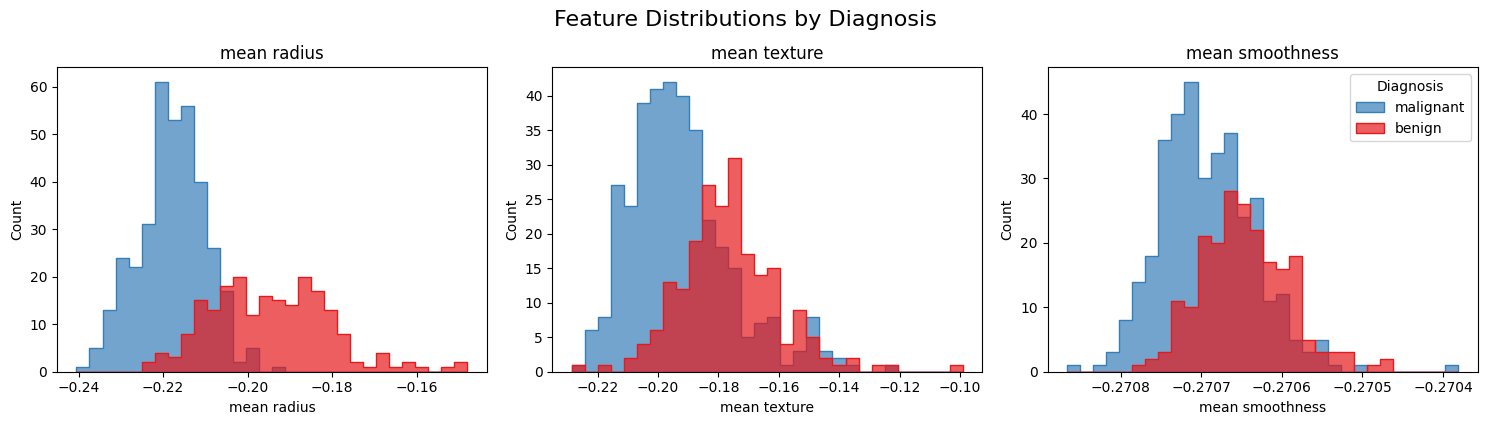

In [37]:
# Visualize distributions of a few features, colored by diagnosis
plt.figure(figsize=(15, 4))
for i, feat in enumerate(['mean radius', 'mean texture', 'mean smoothness']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feat, hue='outcome', palette='Set1', bins=30, alpha=0.7, 
                 legend=(i==2), element="step")
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel('Count')
    if i == 2:
        plt.legend(labels=outcome_names, title='Diagnosis')
plt.tight_layout()
plt.suptitle("Feature Distributions by Diagnosis", fontsize=16, y=1.05)
plt.show()

## Principle Component Analysis (PCA)

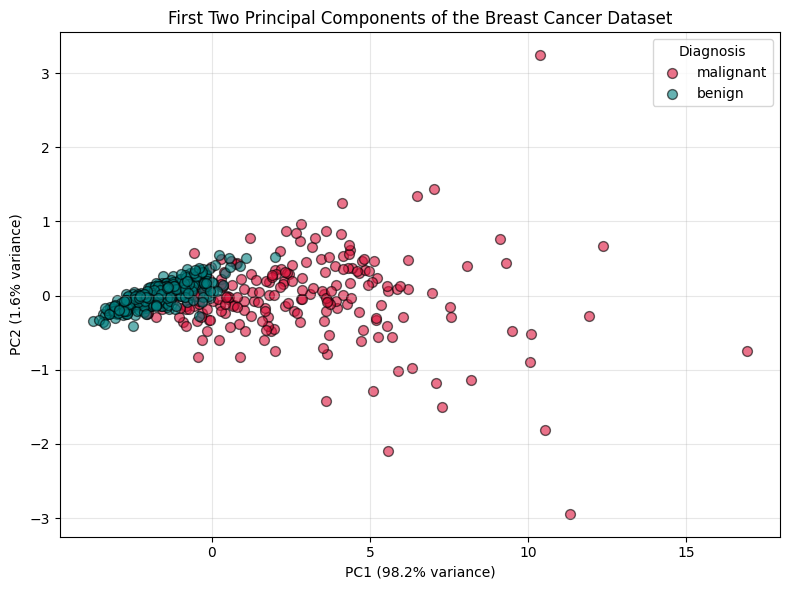

In [38]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for label, name, color in zip([0, 1], outcome_names, ['crimson', 'teal']):
    plt.scatter(X_pca[y == label, 0], 
                X_pca[y == label, 1], 
                alpha=0.6, 
                label=name, 
                c=color, 
                edgecolor='k', 
                s=50)

plt.title("First Two Principal Components of the Breast Cancer Dataset")
plt.xlabel("PC1 ({:.1f}% variance)".format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel("PC2 ({:.1f}% variance)".format(100 * pca.explained_variance_ratio_[1]))
plt.legend(title='Diagnosis')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**PCA Results on Breast Cancer Dataset**
- Groups are not completely separable, showing the limitations of linear dimensionality reduction
- Benign cases (blue) tend to cluster together on the left side of the plot
- Main sources of variation do capture some diagnostic information

## Multidimensional Scaling (MDS)

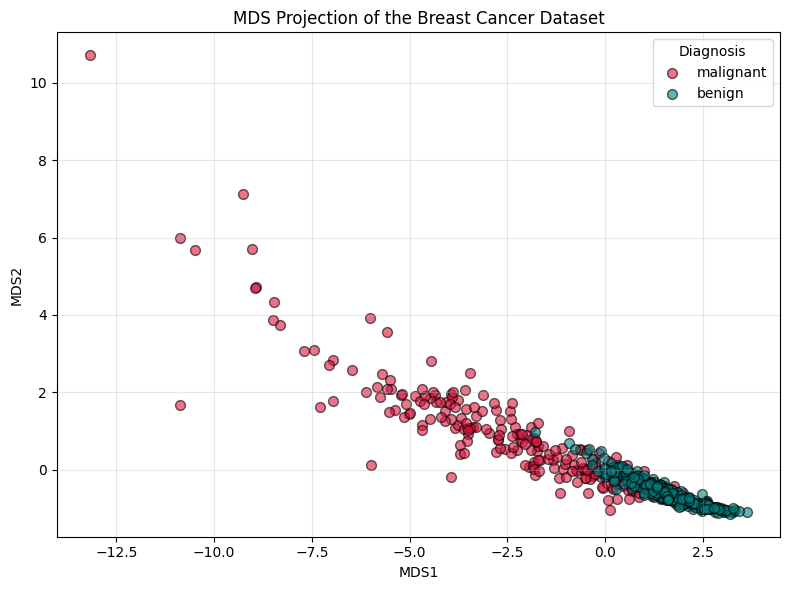

In [5]:
# Fit MDS
mds = MDS(n_components=2, random_state=42, n_init=4, max_iter=300, dissimilarity='euclidean')
X_mds = mds.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for label, name, color in zip([0, 1], outcome_names, ['crimson', 'teal']):
    plt.scatter(X_mds[y == label, 0],
                X_mds[y == label, 1],
                alpha=0.6,
                label=name,
                c=color,
                edgecolor='k',
                s=50)

plt.title("MDS Projection of the Breast Cancer Dataset")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.legend(title='Diagnosis')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**MDS Results on Breast Cancer Dataset**
- Similar to PCA, groups are not distinctly separated, confirming linear method limitations
- Benign cases (blue) cluster together on the right side of the plot
- Malignant cases are more dispersed with greater overlap than in PCA

## t-SNE

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


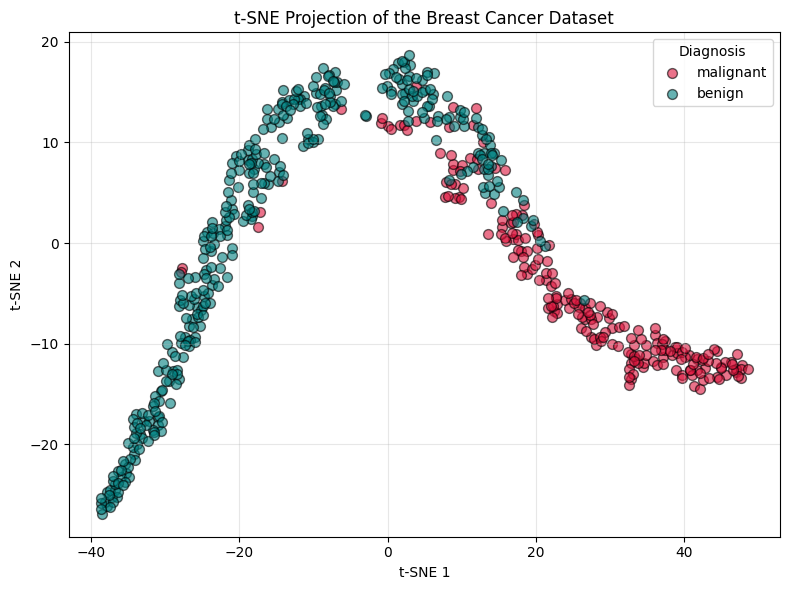

In [6]:
# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for label, name, color in zip([0, 1], outcome_names, ['crimson', 'teal']):
    plt.scatter(X_tsne[y == label, 0],
                X_tsne[y == label, 1],
                alpha=0.6,
                label=name,
                c=color,
                edgecolor='k',
                s=50)

plt.title("t-SNE Projection of the Breast Cancer Dataset")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Diagnosis')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**t-SNE Results on Breast Cancer Dataset**
- Clear separation into two main groups along t-SNE 1 dimension (around x = 0)
- Most benign cases (blue) cluster on the left, malignant cases (red) on the right
- Minimal overlap with only a few benign cases appearing in the malignant cluster
- Demonstrates t-SNE's effectiveness at revealing nonlinear class structure

## UMAP

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


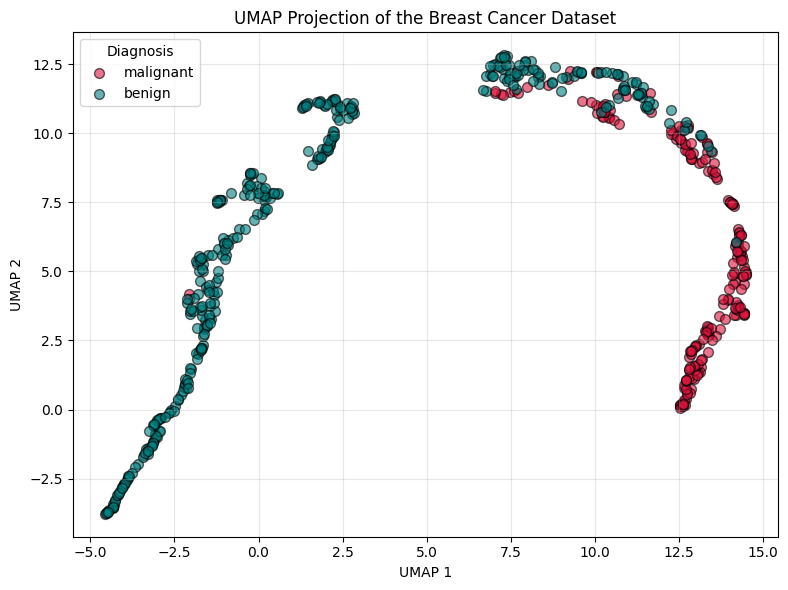

In [7]:
# Fit UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for label, name, color in zip([0, 1], outcome_names, ['crimson', 'teal']):
    plt.scatter(X_umap[y == label, 0],
                X_umap[y == label, 1],
                alpha=0.6,
                label=name,
                c=color,
                edgecolor='k',
                s=50)

plt.title("UMAP Projection of the Breast Cancer Dataset")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Diagnosis')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**UMAP Results on Breast Cancer Dataset**
- Even clearer separation into two distinct groups compared to t-SNE
- Benign cases (blue) form a tight cluster on the left, malignant cases (red) on the right
- Minimal overlap with only a small mixing region between clusters
- Demonstrates UMAP's strength in preserving both local and global structure
- Shows characteristic empty space between well-separated clusters

## Overview 

• **Value of Dimensionality Reduction in Medicine**
  - Uncovers hidden patterns, clusters, and relationships in high-dimensional medical data
  - Supports clinical insight and guides further analysis or decision-making

• **Method Performance Comparison**
  - **Linear methods (PCA, MDS)**: Limited separation due to linear assumptions
  - **Nonlinear methods (t-SNE, UMAP)**: Superior class separation by preserving neighborhood structures

• **Important Limitations**
  - All visualizations are simplifications of complex high-dimensional information
  - Projecting to 2D may obscure important details and relationships
  - Apparent clusters may not always reflect true biological differences

• **Best Practices**
  - Always validate findings with domain knowledge and additional analysis
  - Consider multiple dimensionality reduction techniques for comprehensive understanding
  - Remember that visualization is an exploratory tool, not definitive evidence

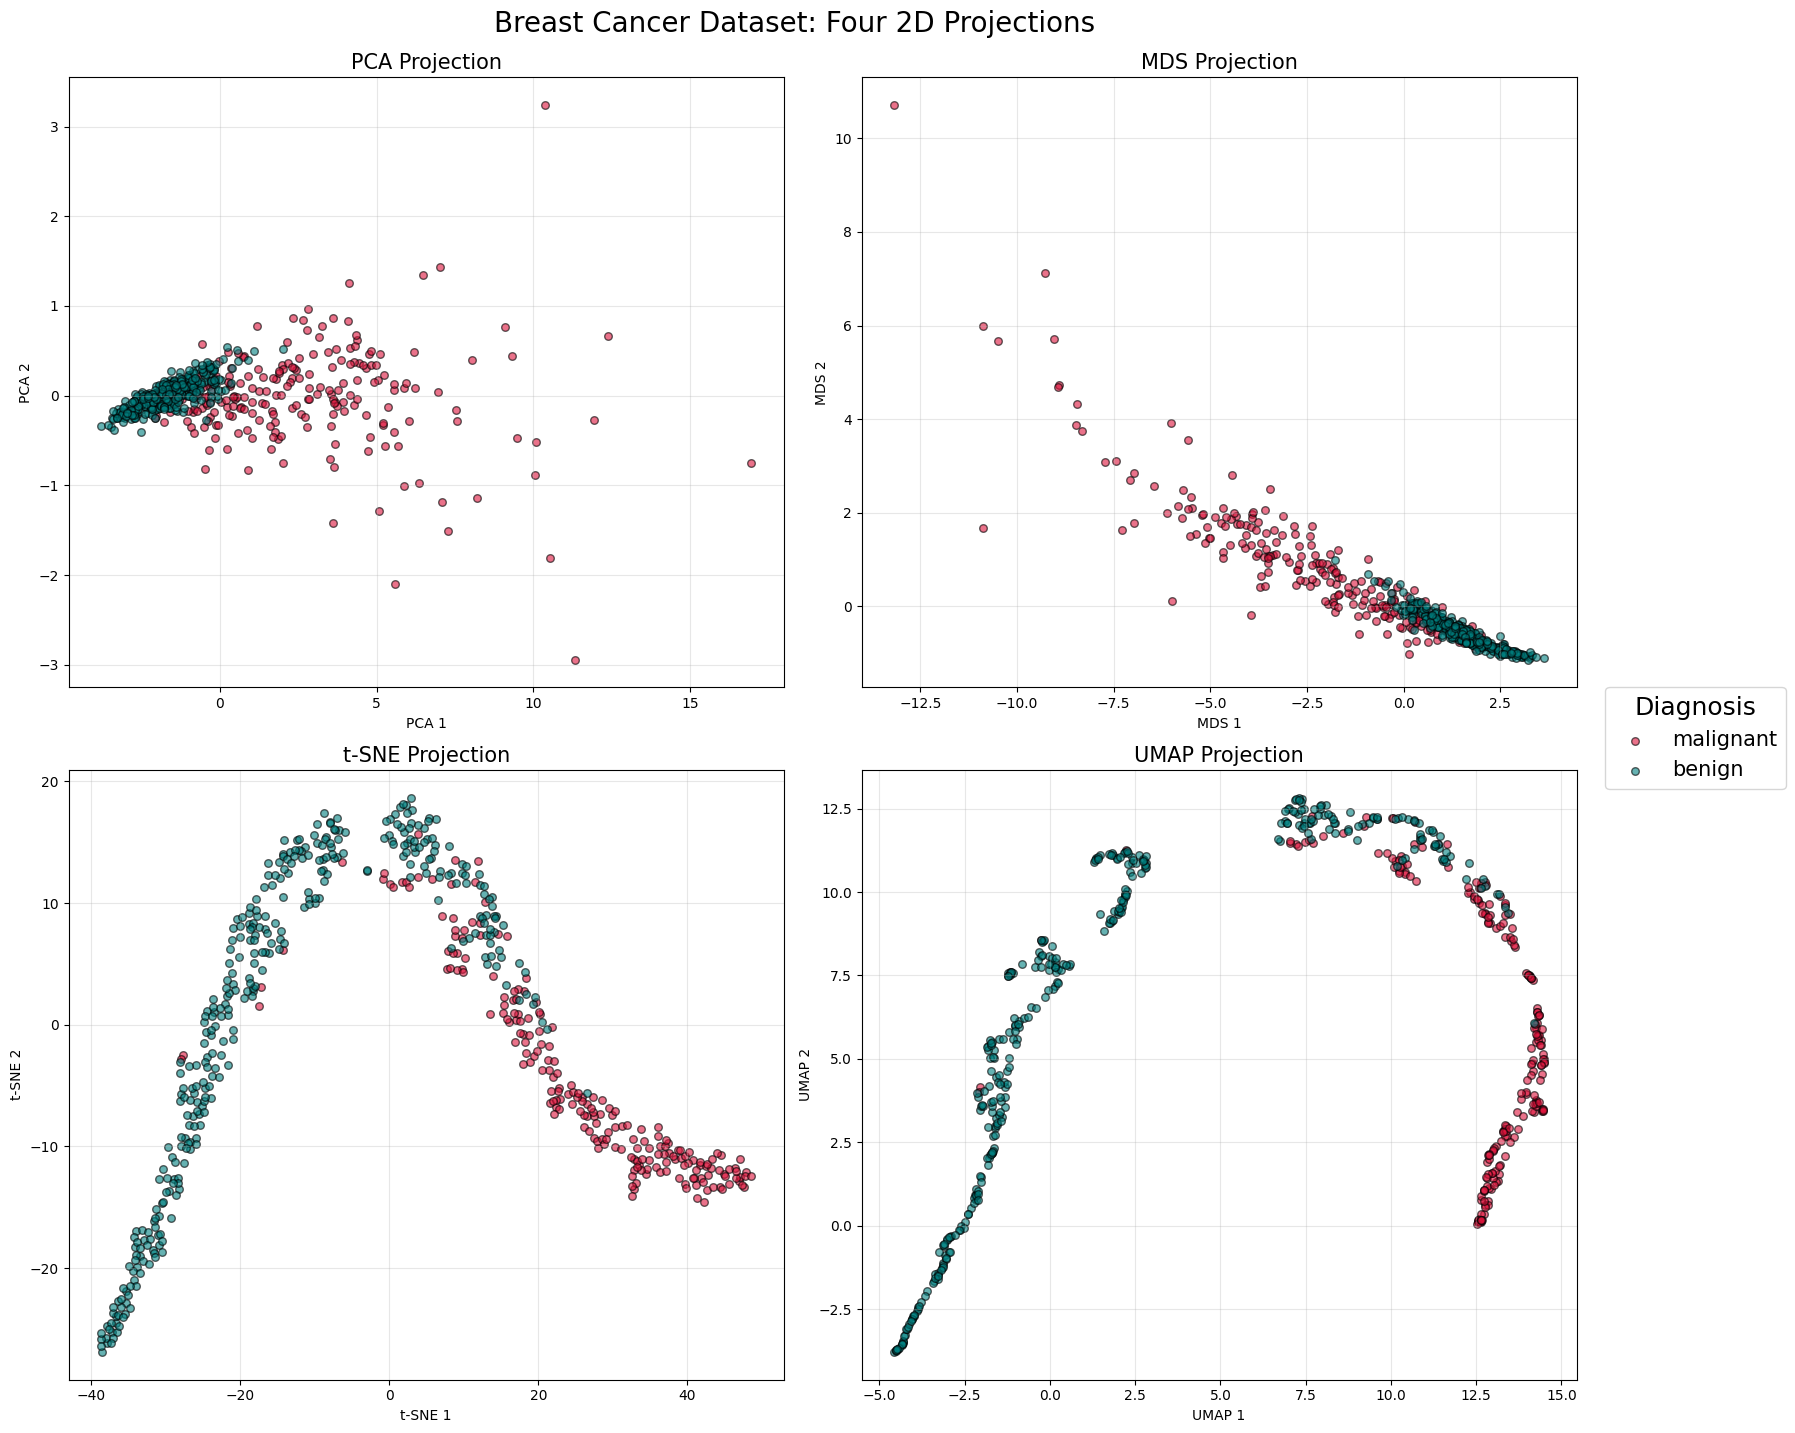

In [ ]:
# Titles and embeddings for easy iteration
titles = [
    "PCA",
    "MDS",
    "t-SNE",
    "UMAP"
]
embeddings = [
    X_pca,
    X_mds,
    X_tsne,
    X_umap
]
colors = ['crimson', 'teal']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for ax, emb, title in zip(axes.ravel(), embeddings, titles):
    for label, name, color in zip([0, 1], outcome_names, colors):
        ax.scatter(emb[y == label, 0],
                   emb[y == label, 1],
                   alpha=0.6,
                   label=name if title == "PCA" else None,  # Only show legend for first plot
                   c=color,
                   edgecolor='k',
                   s=30)
    ax.set_title(title + " Projection", fontsize=15)
    ax.set_xlabel(f"{title} 1")
    ax.set_ylabel(f"{title} 2")
    ax.grid(alpha=0.3)
    if title == "PCA":
        handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title_fontsize=18, title='Diagnosis')

plt.tight_layout()
plt.suptitle("Breast Cancer Dataset: Four 2D Projections", fontsize=20, y=1.02)
plt.show()

---
<br><br>
# 3. Similarity Measures

The dimensionality reduction techniques we explored—PCA, MDS, t-SNE, and UMAP—all rely on one fundamental concept: **measuring how similar or different data points are to each other**. While these visualizations allowed us to see patterns and clusters, we've been judging similarity only through visual inspection.

**The Missing Piece:** To move beyond visual interpretation, we need precise mathematical tools to quantify similarity and distance between patients or data points.

This section explores various distance and similarity metrics, providing the foundation underlying dimensionality reduction and many other machine learning applications.

## Similarity Metrics for Continuous Data

When working with patient measurements or medical test results, it’s often important to compare how similar or different two cases are. **Similarity metrics** (or *distance measures*) provide a mathematical way to quantify how close two data points are in a dataset with continuous values.

Two of the most common metrics are:

- **Euclidean distance:** Measures the straight-line distance between two points, much like using a ruler. It’s intuitive—cases are “closer” if their values across all features are more similar.
- **Manhattan distance:** Also called “city block” distance, this adds up the absolute differences across all features, similar to navigating a city grid. It is less sensitive to large differences in any single measurement.

Before we use these metrics on a medical dataset, let's make a simple example to illustrate these metrics.

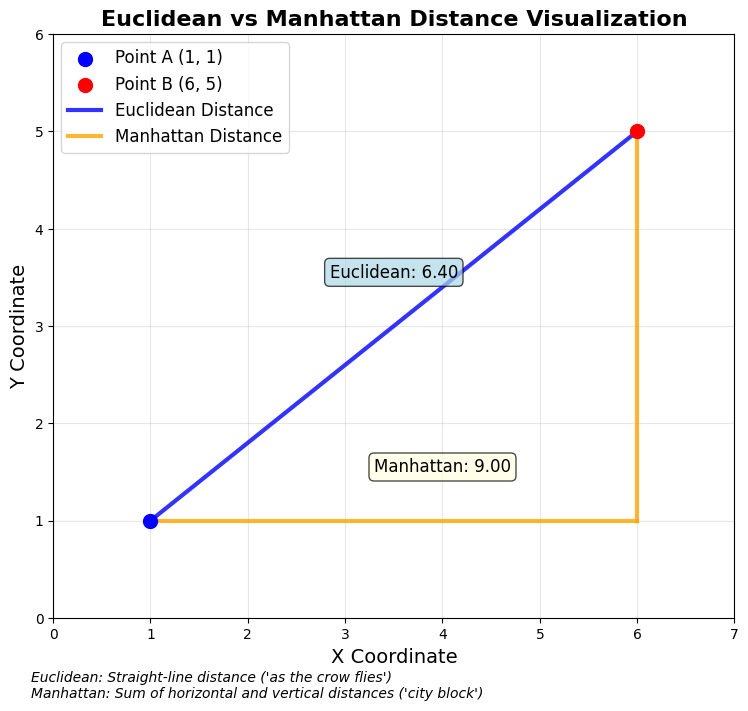

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Define two points
point_A = np.array([1, 1])
point_B = np.array([6, 5])

# Plot the points
ax.scatter(*point_A, color='blue', s=100, zorder=5, label='Point A (1, 1)')
ax.scatter(*point_B, color='red', s=100, zorder=5, label='Point B (6, 5)')

# Euclidean distance (straight line)
ax.plot([point_A[0], point_B[0]], [point_A[1], point_B[1]], 
        color='blue', linewidth=3, label='Euclidean Distance', alpha=0.8)

# Manhattan distance (L-shaped path)
# First go horizontally, then vertically
ax.plot([point_A[0], point_B[0]], [point_A[1], point_A[1]], 
        color='orange', linewidth=3, alpha=0.8)
ax.plot([point_B[0], point_B[0]], [point_A[1], point_B[1]], 
        color='orange', linewidth=3, alpha=0.8, label='Manhattan Distance')

# Add grid
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Calculate and display distances
euclidean_dist = np.sqrt((point_B[0] - point_A[0])**2 + (point_B[1] - point_A[1])**2)
manhattan_dist = abs(point_B[0] - point_A[0]) + abs(point_B[1] - point_A[1])

# Add distance annotations
ax.text(3.5, 3.5, f'Euclidean: {euclidean_dist:.2f}', 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
        fontsize=12, ha='center')

ax.text(4, 1.5, f'Manhattan: {manhattan_dist:.2f}', 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7),
        fontsize=12, ha='center')

# Labels and title
ax.set_xlabel('X Coordinate', fontsize=14)
ax.set_ylabel('Y Coordinate', fontsize=14)
ax.set_title('Euclidean vs Manhattan Distance Visualization', fontsize=16, fontweight='bold')

# Set axis limits
ax.set_xlim(0, 7)
ax.set_ylim(0, 6)

# Add legend
ax.legend(loc='upper left', fontsize=12)

# Adjust layout to make room for text at bottom
plt.subplots_adjust(bottom=0.15)

# Add explanatory text (moved higher)
plt.figtext(0.15, 0.05, 
           "Euclidean: Straight-line distance ('as the crow flies')\n"
           "Manhattan: Sum of horizontal and vertical distances ('city block')", 
           fontsize=10, style='italic')

plt.show()

In the following examples, we’ll use the Breast Cancer Wisconsin dataset to illustrate how these metrics work in practice and how they help us understand the similarity between patient profiles.

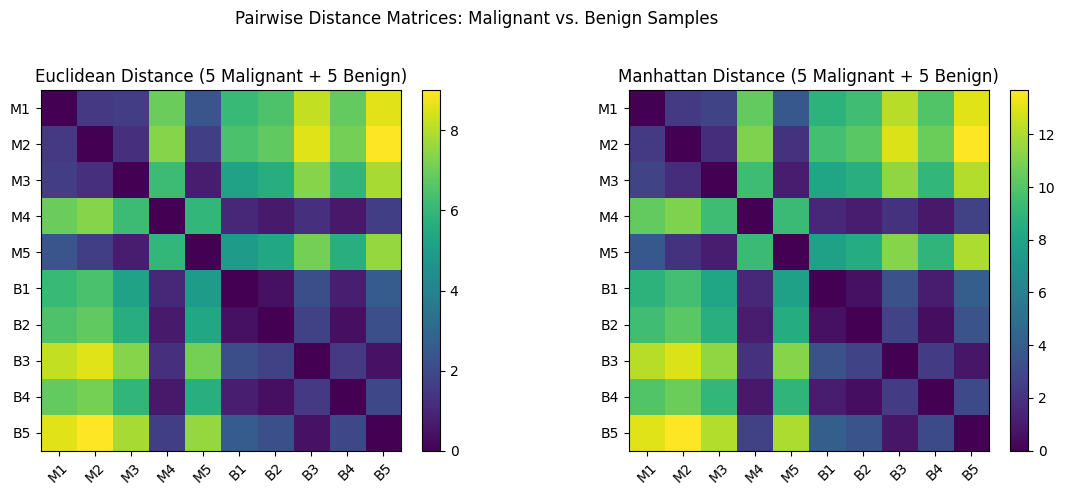

In [42]:
# Compute the full distance matrices
euclidean_dist = pairwise_distances(X, metric='euclidean')
manhattan_dist = pairwise_distances(X, metric='manhattan')

# Find indices for first 5 malignant and first 5 benign samples
malignant_indices = np.where(y == 0)[0][:5]  # assuming 0 = malignant
benign_indices = np.where(y == 1)[0][:5]     # assuming 1 = benign

# Combine indices (first 5 malignant, then first 5 benign)
selected_indices = np.concatenate([malignant_indices, benign_indices])

# Extract the 10x10 submatrix for these specific samples
euclidean_selected = euclidean_dist[np.ix_(selected_indices, selected_indices)]
manhattan_selected = manhattan_dist[np.ix_(selected_indices, selected_indices)]

# Create labels for the plot
labels = ['M1', 'M2', 'M3', 'M4', 'M5', 'B1', 'B2', 'B3', 'B4', 'B5']

# Plot the similarity (distance) matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, mat, title in zip(
    axes,
    [euclidean_selected, manhattan_selected],
    ["Euclidean Distance (5 Malignant + 5 Benign)", "Manhattan Distance (5 Malignant + 5 Benign)"]
):
    im = ax.imshow(mat, cmap='viridis', interpolation='nearest')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Pairwise Distance Matrices: Malignant vs. Benign Samples")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Visualizing Similarity Matrices

A **similarity matrix** (or, more precisely in this case, a *distance matrix*) provides a summary of how close or far apart each pair of samples is in our dataset. Each cell in the matrix shows the distance between two samples: smaller values mean the samples are more similar, while larger values indicate greater differences. By visualizing these matrices as heatmaps, we can quickly spot patterns or clusters among the samples.

However, as datasets grow larger and more complex, these matrices become difficult to interpret directly. To better understand the relationships represented by these distances, we can use dimensionality reduction techniques like **PCA** and **t-SNE**. These methods allow us to project the complex patterns in the distance matrix into two dimensions, making it easier to identify clusters and trends visually.

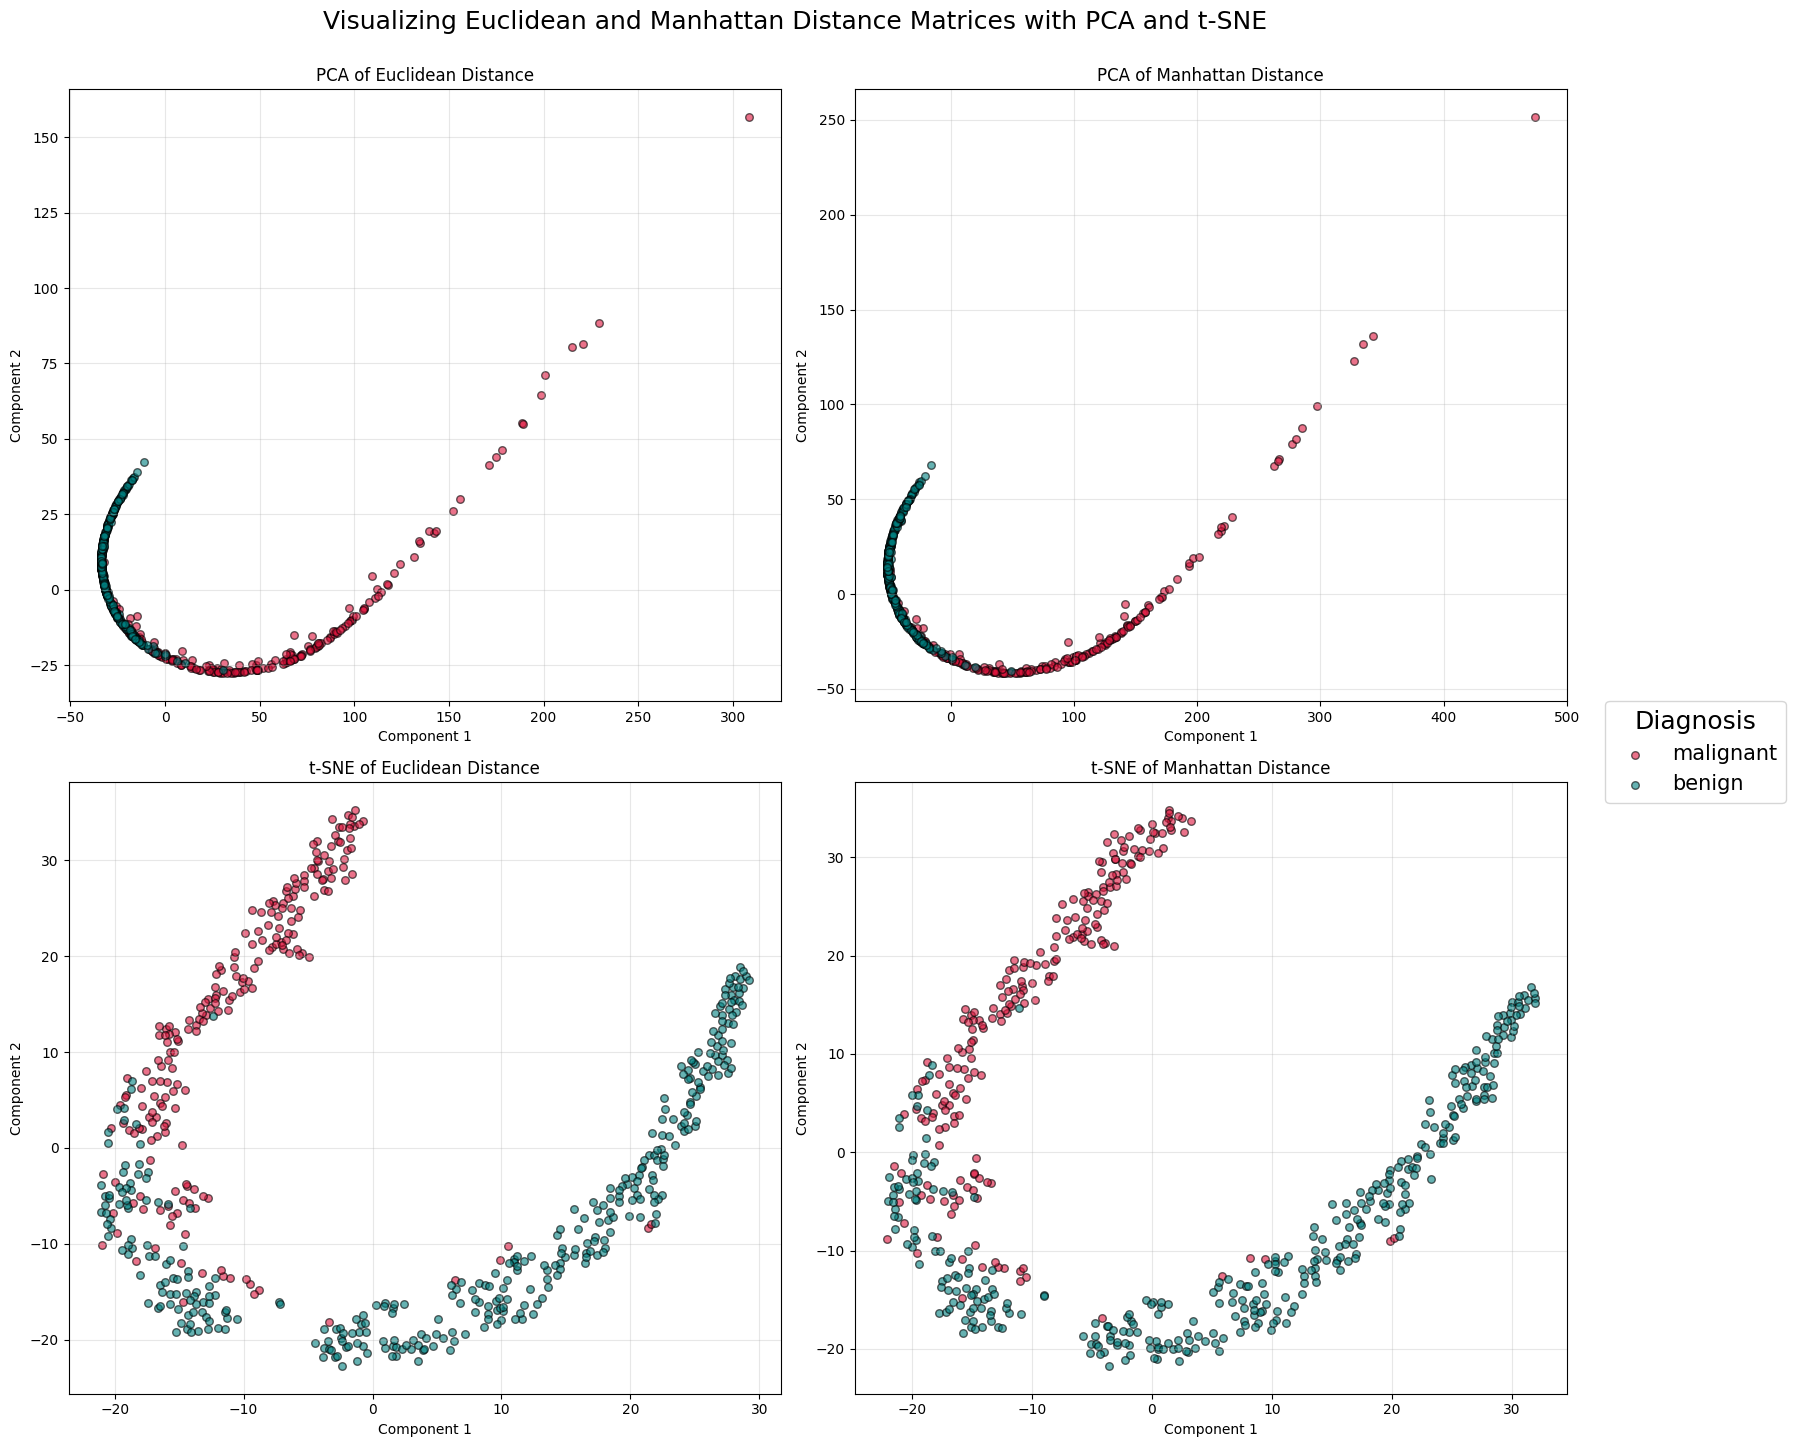

In [43]:
# PCA on distance matrices
pca = PCA(n_components=2)
X_pca_euclidean = pca.fit_transform(euclidean_dist)
X_pca_manhattan = pca.fit_transform(manhattan_dist)

# t-SNE on distance matrices
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
X_tsne_euclidean = tsne.fit_transform(euclidean_dist)
X_tsne_manhattan = tsne.fit_transform(manhattan_dist)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

embeddings = [
    (X_pca_euclidean, "PCA of Euclidean Distance"),
    (X_pca_manhattan, "PCA of Manhattan Distance"),
    (X_tsne_euclidean, "t-SNE of Euclidean Distance"),
    (X_tsne_manhattan, "t-SNE of Manhattan Distance"),
]

for ax, (emb, title) in zip(axes.ravel(), embeddings):
    for label, name, color in zip([0, 1], outcome_names, ['crimson', 'teal']):
        ax.scatter(emb[y == label, 0], emb[y == label, 1],
                   alpha=0.6, label=name if title.startswith("PCA") else None,
                   c=color, edgecolor='k', s=30)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(alpha=0.3)
    if title.startswith("PCA"):
        handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title_fontsize=18, title='Diagnosis')


plt.tight_layout()
plt.suptitle("Visualizing Euclidean and Manhattan Distance Matrices with PCA and t-SNE", y=1.03, fontsize=18)
plt.show()

## Similarity Metrics for Categorical Data

When analyzing patient records or clinical survey results, data often comes in the form of categories—such as “yes/no” answers, types of symptoms, or classifications. **Similarity metrics** for categorical data provide a mathematical way to compare how alike two cases are, even when values are not numeric.

In the following examples, we’ll use the Stroke Prediction dataset to illustrate how these metrics can help us understand similarities between patient profiles based on categorical and binary clinical features.

### Introduction to the Heart Disease Dataset

The **Heart Disease Dataset** is a widely-used clinical dataset from the UCI Machine Learning Repository that focuses on predicting the presence of heart disease based on various cardiovascular risk factors and diagnostic measurements. Originally collected from four medical institutions (Cleveland, Hungary, Switzerland, and Long Beach VA), this dataset has become a benchmark for medical machine learning applications.

- **Samples:** 303 patient records (after removing missing values)
- **Features:** 13 variables including both categorical (e.g., sex, chest pain type, exercise-induced angina) and numerical (e.g., age, blood pressure, cholesterol level, maximum heart rate) data
- **Label:** 
    - `0` = no heart disease
    - `1` = presence of heart disease (originally 1-4 severity levels, converted to binary)
- **Data type:** A mix of categorical and numerical features
- **Missing values:** Some missing values in `ca` (number of major vessels) and `thal` (thalassemia type)
- [Link for more information](https://archive.ics.uci.edu/dataset/45/heart+disease)

In [59]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Combine features and targets for easier processing
df = pd.concat([X, y], axis=1)

# Handle missing values
df = df.dropna()

# Convert target to binary (0 = no heart disease, 1+ = heart disease)
df['num'] = (df['num'] > 0).astype(int) 

In [55]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    1  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 34.8 KB


In [57]:
df.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    1.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    1.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    2.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    3.000000    3.000000   

             thal         num  
count  297.000000  297.000000  
mean     4.730640    0.461279  
std      1.938629    0.499340  
min      3.000000    0.000000  
25%      3.000000    0.000000  
50%      3.000000    0.000000  
75%      7.000000    1.000000  
max      7.000000    1.000000

In [58]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

For this section, we focus on the **categorical and binary features** to explore similarity metrics designed for categorical data. Let's clean up our data, such that we don't include numerical data.

In [61]:
# Select categorical/binary features for distance calculations
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df_cat = df[categorical_features]

# Convert to numeric format
X = df_cat.astype(float).values
y = df['num'].values
outcome_names = ['No Heart Disease', 'Heart Disease']

Having explored the structure and content of the Heart Disease dataset, we’re now ready to examine how different similarity metrics behave when applied to real patient data. By calculating and visualizing the resulting similarity (or distance) matrices, we can gain insights into the patterns, clusters, and relationships among patients based on their categorical risk factors. 

Three commonly used metrics for categorical data are:

- **Simple Matching Coefficient:** This metric counts the proportion of features where two cases share the same category. It treats matches of presence and absence equally.
- **Jaccard Similarity:** This metric focuses only on features where at least one case has a “yes” (or presence), ignoring cases where both are “no.” It’s particularly useful when the presence of a trait is more important than its absence.
- **Hamming Distance:** This measures the total number of positions where two cases differ. In other words, it counts how many features would need to change for the two cases to match exactly.

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


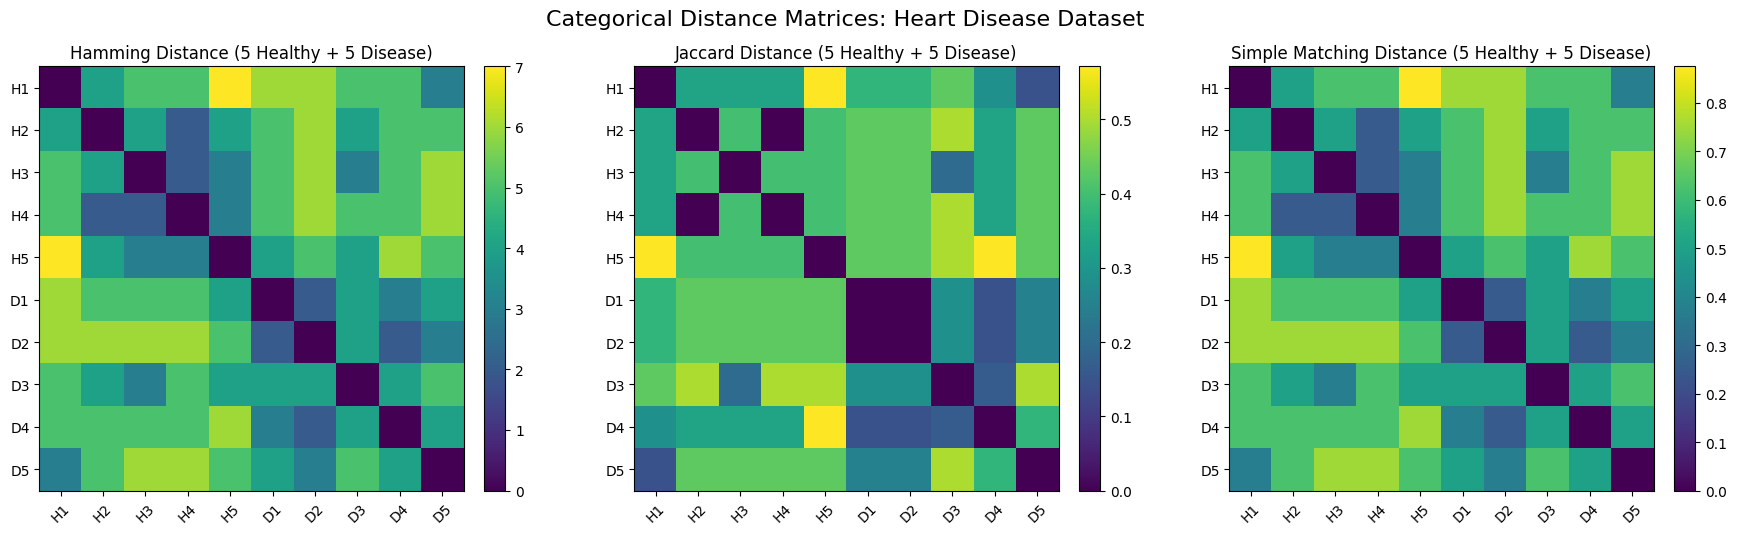

In [63]:
# Find indices for first 5 of each target value
no_disease_indices = np.where(y == 0)[0][:5]  # First 5 without heart disease
disease_indices = np.where(y == 1)[0][:5]     # First 5 with heart disease

# Combine indices
selected_indices = np.concatenate([no_disease_indices, disease_indices])

# 1. Hamming Distance
hamming_dist = pairwise_hamming_distance_similarity(X)
hamming_selected = hamming_dist[np.ix_(selected_indices, selected_indices)]

# 2. Jaccard Distance
jaccard_dist = pairwise_distances(X, metric='jaccard')
jaccard_selected = jaccard_dist[np.ix_(selected_indices, selected_indices)]

# 3. Simple Matching Distance
simple_matching_dist = simple_matching_distance(X)
simple_matching_selected = simple_matching_dist[np.ix_(selected_indices, selected_indices)]

# Create labels for the plot
labels = ['H1', 'H2', 'H3', 'H4', 'H5', 'D1', 'D2', 'D3', 'D4', 'D5']

# 4. Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = [
    "Hamming Distance (5 Healthy + 5 Disease)",
    "Jaccard Distance (5 Healthy + 5 Disease)",
    "Simple Matching Distance (5 Healthy + 5 Disease)"
]
matrices = [hamming_selected, jaccard_selected, simple_matching_selected]

for ax, mat, title in zip(axes, matrices, titles):
    im = ax.imshow(mat, cmap='viridis', interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("Categorical Distance Matrices: Heart Disease Dataset", fontsize=16, y=1.05)
plt.show()

**Key Observations:**

- We calculated similarity matrices using the three different categorical distance metrics and visualized them for the first 5 healthy patients (H1-H5) and first 5 patients with heart disease (D1-D5)

- Notice the darker diagonal blocks in the top-left (H1-H5) and bottom-right (D1-D5) corners, suggesting that patients within the same health status tend to be more similar to each other

- The off-diagonal blocks (top-right and bottom-left) generally show brighter colors, indicating that healthy and diseased patients are more dissimilar from each other

To better understand the relationships and potential clusters in the data, let’s project these distances into two dimensions using **PCA** and **t-SNE**.

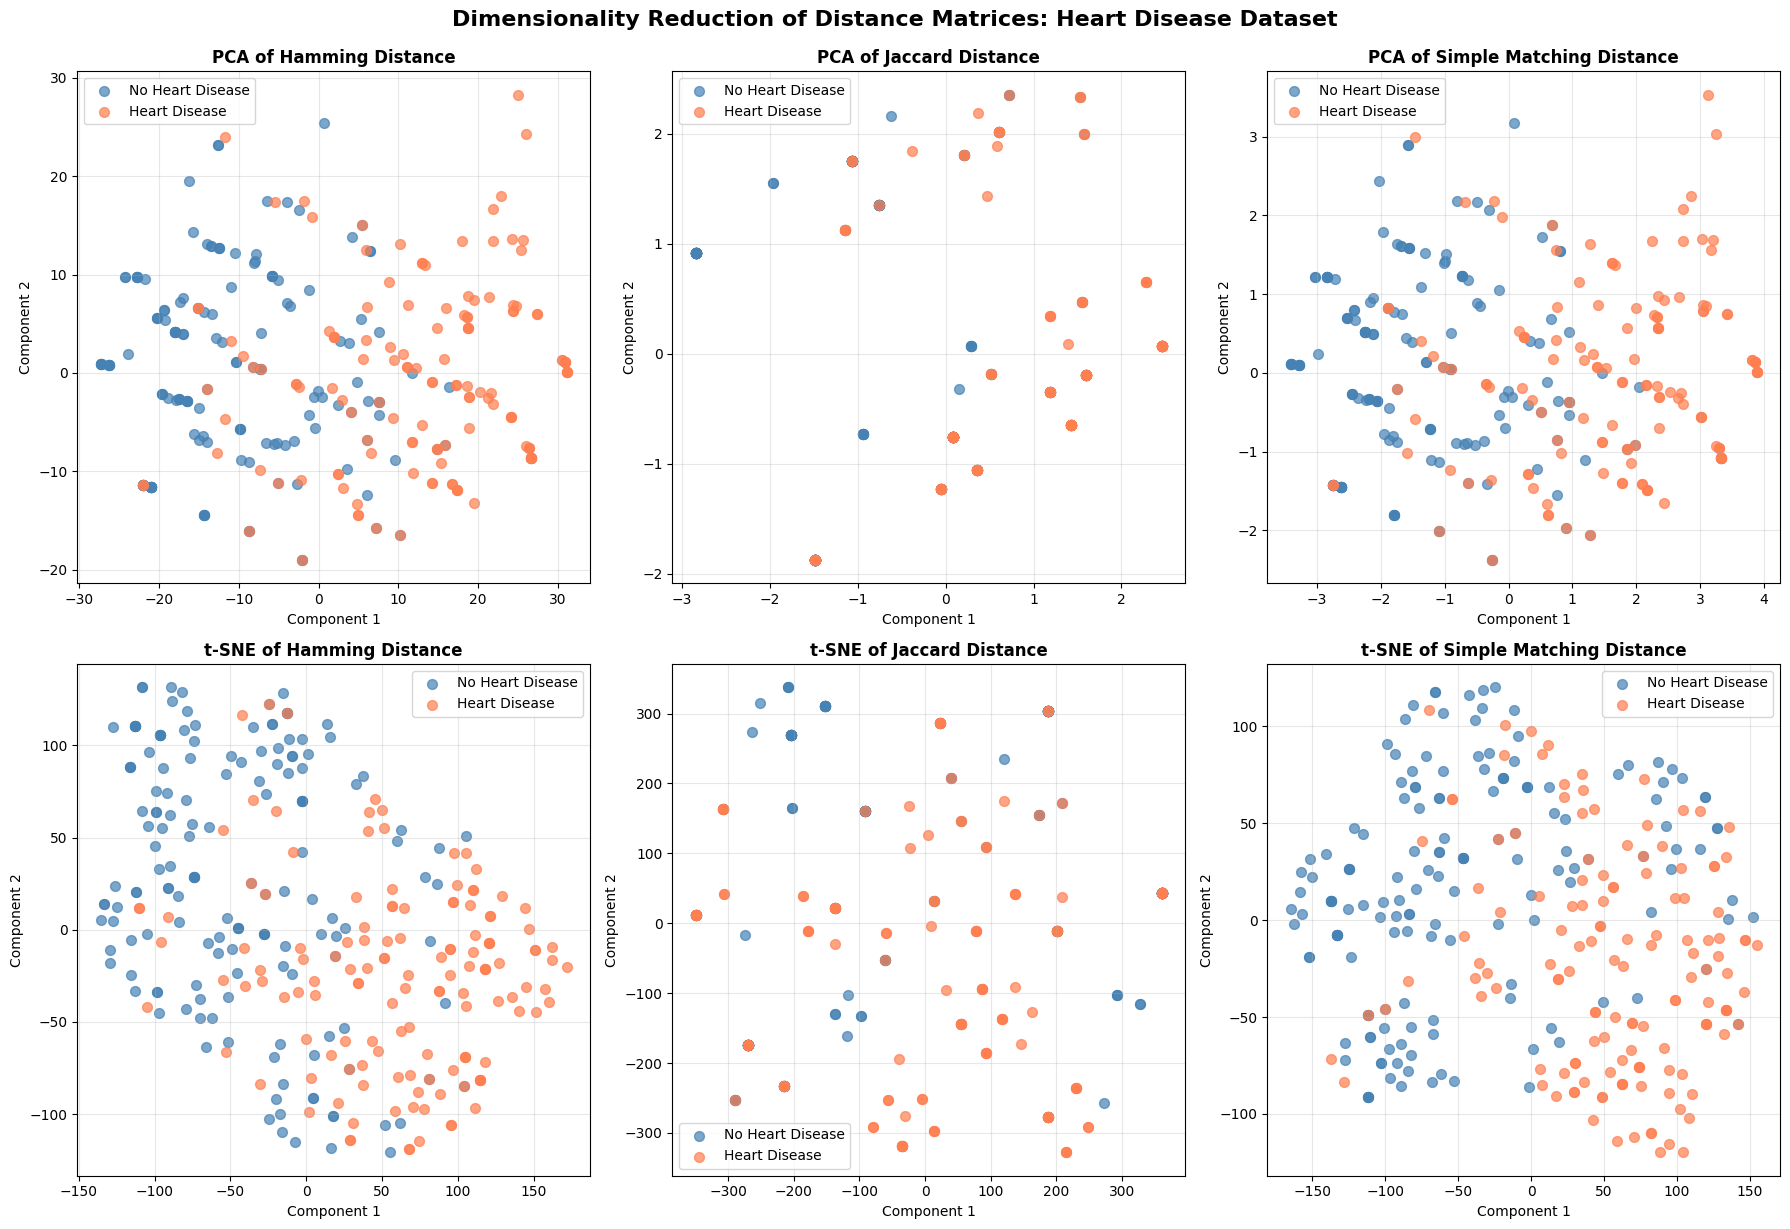

In [64]:
# Apply PCA to each distance matrix
pca = PCA(n_components=2, random_state=42)
hamming_pca = pca.fit_transform(hamming_dist)
jaccard_pca = pca.fit_transform(jaccard_dist)
simple_matching_pca = pca.fit_transform(simple_matching_dist)

# Apply t-SNE to each distance matrix
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
hamming_tsne = tsne.fit_transform(hamming_dist)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
jaccard_tsne = tsne.fit_transform(jaccard_dist)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
simple_matching_tsne = tsne.fit_transform(simple_matching_dist)

# Create the plot with all 6 combinations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Define colors for the two classes
colors = ['steelblue', 'coral']
labels = ['No Heart Disease', 'Heart Disease']

# Plot configurations
plot_configs = [
    (hamming_pca, "PCA of Hamming Distance", axes[0, 0]),
    (jaccard_pca, "PCA of Jaccard Distance", axes[0, 1]),
    (simple_matching_pca, "PCA of Simple Matching Distance", axes[0, 2]),
    (hamming_tsne, "t-SNE of Hamming Distance", axes[1, 0]),
    (jaccard_tsne, "t-SNE of Jaccard Distance", axes[1, 1]),
    (simple_matching_tsne, "t-SNE of Simple Matching Distance", axes[1, 2])
]

# Create scatter plots
for data, title, ax in plot_configs:
    for i, (label, color) in enumerate(zip(labels, colors)):
        mask = y == i
        ax.scatter(data[mask, 0], data[mask, 1], 
                  c=color, label=label, alpha=0.7, s=50)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Dimensionality Reduction of Distance Matrices: Heart Disease Dataset", 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

**Key Observations:**

We applied PCA (top row) and t-SNE (bottom row) to the distance matrices computed using three categorical similarity metrics, projecting each patient into a 2D space for visualization

• **PCA Results (Linear Projection):**
  - Shows relatively gradual separation between healthy and diseased patients
  - Hamming and Simple Matching distances show similar clustering patterns
  - Jaccard distance appears to provide the most scattered distribution in PCA space

• **t-SNE Results (Non-linear Projection):**
  - Reveals more distinct clustering patterns compared to PCA
  - Creates clearer visual separation between patient groups
  - Better preserves local neighborhood structures from the original high-dimensional distance space

The clear clustering visible in t-SNE projections suggests that categorical cardiovascular risk factors capture meaningful patterns that distinguish between healthy patients and those with heart disease, with non-linear dimensionality reduction revealing these patterns more effectively than linear methods

### Similarity Metrics for Mixed Data

Healthcare datasets typically contain mixed data types:
- Numerical values (age, blood pressure, cholesterol levels)
- Categorical information (gender, chest pain type, exercise-induced symptoms)

**Gower's dissimilarity** addresses this by:
- Combining numeric and categorical differences into a single similarity measure
- Automatically normalizing continuous variables
- Handling categorical variables appropriately

We'll demonstrate Gower's metric on the Heart Disease dataset using all relevant features to show how it provides a comprehensive view of patient similarity across mixed data types.

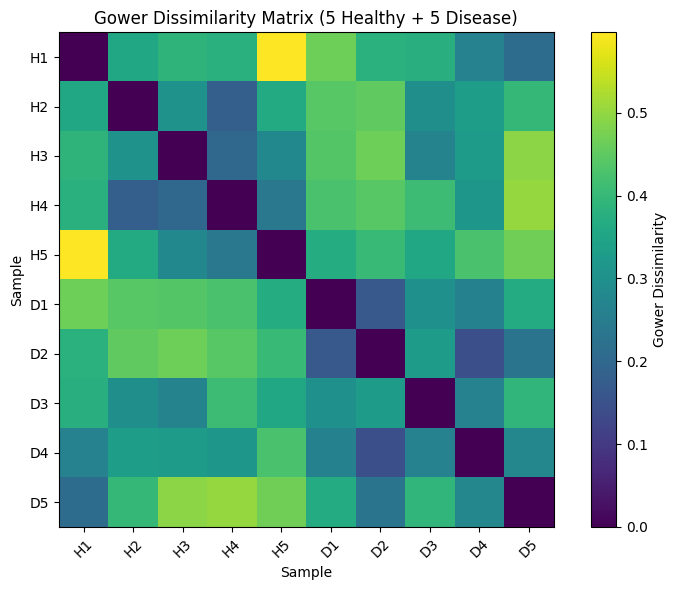

In [65]:
import gower

# Select features: mix of numerical and categorical for Heart Disease dataset
# We'll use both continuous and categorical features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Combine all features for Gower distance
gower_features = continuous_features + categorical_features
df_gower = df[gower_features + ['num']]  # include target for later use

# For plotting, ensure no missing values
df_gower = df_gower.dropna().reset_index(drop=True)

# Separate outcome for coloring
y_gower = df_gower['num'].values
outcome_names = ['No Heart Disease', 'Heart Disease']

# Drop outcome from Gower calculation
X_gower = df_gower.drop(columns=['num'])

# Calculate Gower dissimilarity matrix (this returns a full n x n matrix)
gower_dist = gower.gower_matrix(X_gower)

# Find indices for first 5 of each target value (consistent with previous plots)
no_disease_indices = np.where(y_gower == 0)[0][:5]  # First 5 without heart disease
disease_indices = np.where(y_gower == 1)[0][:5]     # First 5 with heart disease
selected_indices = np.concatenate([no_disease_indices, disease_indices])

# Extract the 10x10 submatrix for these specific samples
gower_selected = gower_dist[np.ix_(selected_indices, selected_indices)]

# Create labels for the plot
labels = ['H1', 'H2', 'H3', 'H4', 'H5', 'D1', 'D2', 'D3', 'D4', 'D5']

# Plot Gower dissimilarity matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(gower_selected, cmap='viridis', interpolation='nearest')
plt.title("Gower Dissimilarity Matrix (5 Healthy + 5 Disease)")
plt.xticks(range(10), labels, rotation=45)
plt.yticks(range(10), labels)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar(im, label='Gower Dissimilarity')
plt.tight_layout()
plt.show()

**Key Observations:**

• **Group Patterns:** Similar to the categorical distance matrices, we observe higher similarity within healthy patients (H1-H5) and diseased patients (D1-D5), with lower similarity between the two groups

• **Enhanced Separation:** The difference between healthy and diseased patients appears more pronounced than with purely categorical metrics, suggesting that incorporating continuous variables strengthens the discriminative power of the similarity measure

To further explore these relationships, we again project the dissimilarities into two dimensions using PCA and t-SNE.

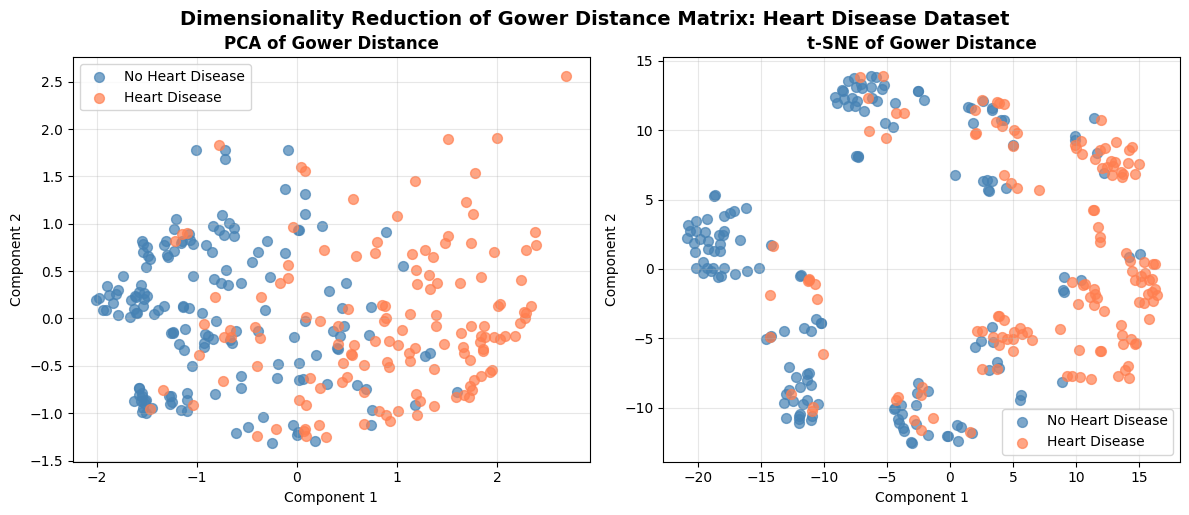

In [66]:
# Apply PCA to Gower distance matrix
pca = PCA(n_components=2, random_state=42)
gower_pca = pca.fit_transform(gower_dist)

# Apply t-SNE to Gower distance matrix
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
gower_tsne = tsne.fit_transform(gower_dist)

# Create the plot with both PCA and t-SNE for Gower distance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define colors for the two classes
colors = ['steelblue', 'coral']
labels = ['No Heart Disease', 'Heart Disease']

# Plot configurations
plot_configs = [
    (gower_pca, "PCA of Gower Distance", axes[0]),
    (gower_tsne, "t-SNE of Gower Distance", axes[1])
]

# Create scatter plots
for data, title, ax in plot_configs:
    for i, (label, color) in enumerate(zip(labels, colors)):
        mask = y_gower == i
        ax.scatter(data[mask, 0], data[mask, 1], 
                  c=color, label=label, alpha=0.7, s=50)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Dimensionality Reduction of Gower Distance Matrix: Heart Disease Dataset", 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

**Key Observations:**

• **Clustering Patterns:** Both PCA and t-SNE reveal clustering of patients, with some separation between healthy (blue) and diseased (orange) groups

• **Multiple Clusters in t-SNE:** The t-SNE visualization shows more distinct clusters than just the binary disease/no disease classification, which seems reasonable given that there could be a range of heart disease types and severity levels

• **Mixed Data Benefits:** By incorporating both continuous and categorical features, Gower distance captures more nuanced patient similarities that reveal subclusters within the broad disease categories

## Overview Similarity

Choosing the right similarity or distance metric is crucial for meaningful comparisons in biomedical datasets. Here's a summary of the main metrics we explored, organized by data type and their applications:

**Numeric Features**
- **Euclidean Distance:**  
  - Measures the straight-line ("as the crow flies") distance between two points in feature space
  - *Best for:* Continuous, numeric data with similar scales (e.g., lab results or vital signs)

- **Manhattan Distance:**  
  - Sums the absolute differences across all features ("city block" distance)
  - *Best for:* Continuous or ordinal data, especially when you want less sensitivity to outliers

**Categorical Features**
- **Jaccard Distance:**  
  - Focuses on the proportion of non-shared "present" features (ignores shared absences)
  - *Best for:* Binary or multi-label categorical data where presence is more important than absence (e.g., comorbidities, symptoms)

- **Hamming Distance:**  
  - Counts the number of features that differ between two vectors
  - Works with both binary and multinomial categorical data, but treats all mismatches equally
  - *Best for:* Binary categorical data or nominal multinomial data where all categories are equally different (e.g., yes/no responses, color categories)

- **Simple Matching Coefficient:**  
  - Reflects the ratio of features that are the same between two vectors
  - Extends naturally to multinomial data by counting exact matches vs. mismatches
  - *Best for:* Binary data where both "yes" and "no" matches are equally informative, or nominal multinomial data without inherent ordering

**Mixed Features**
- **Gower's Dissimilarity:**  
  - Combines differences from both numerical and categorical features into a single measure
  - Automatically handles normalization and different data types
  - *Best for:* Datasets with mixed data types (continuous + categorical), such as most clinical records

**Choosing a metric depends on your data and your question:**  
- Use **Euclidean** or **Manhattan** for all-numeric features
- Use **Jaccard**, **Hamming**, or **Simple Matching** when working with binary or categorical-only data
- Use **Gower** when your dataset has a mix of numerical and categorical variables

*The right metric helps ensure that your similarity-based analyses and models reflect the real structure and meaning in your data.*